<a href="https://colab.research.google.com/github/dduniverse/ML-study/blob/main/11.%20LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LightGBM
XGBoost 이후로 나온 최신 부스팅 모델
- 리프 중심 트리 분할 방식 사용

|장점|단점|
|---|---|
|XGBoost보다도 빠르고 높은 정확도를 보여주는 경우가 많음|복잡한 모델인 만큼, 해석에 어려움이 있음|
|예측에 영향을 미친 변수의 중요도를 확인할 수 있음|하이퍼파라미터 튜닝이 까다로움|
|변수 종류가 많고 데이터가 클수록 상대적으로 뛰어난 성능을 보여줌| |


- 종속변수가 연속형 데이터인 경우든 범주형 데이터인 경우든 모두 사용할 수 있음
- 이미지나 자연어가 아닌 표로 정리된 데이터라면 거의 모든 상황에서 활용할 수 있음

## 라이브러리 및 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_url = 'https://media.githubusercontent.com/media/musthave-ML10/data_source/main/fraud.csv'
data = pd.read_csv(file_url)
data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   trans_date_trans_time  object 
 1   cc_num                 int64  
 2   merchant               object 
 3   category               object 
 4   amt                    float64
 5   first                  object 
 6   last                   object 
 7   gender                 object 
 8   street                 object 
 9   city                   object 
 10  state                  object 
 11  zip                    int64  
 12  lat                    float64
 13  long                   float64
 14  city_pop               int64  
 15  job                    object 
 16  dob                    object 
 17  trans_num              object 
 18  unix_time              int64  
 19  merch_lat              float64
 20  merch_long             float64
 21  is_fraud               int64  
dtypes: float64(5), int

- trans_data_trans_time: 거래 시간
- cc_num: 카드 번호(고유값)
- merchant: 거래 상점
- category: 거래 상점의 범주(애완용품, 여행, 엔터테인먼트 등)
- amt: 거래 금액
- first/last: 이름
- gender: 성별
- street/city/state/zip: 고객 거주지 정보
- lat/long: 고객 주소에 대한 위도 및 경도
- city_pop: 고객의 zipcode에 속하는 인구 수
- job: 직업
- dob: 생년월일
- trans_num: 거래 번호
- unix_time: 거래 시간(유닉스 타임스탬프 형식)
- merch_lat/merch_long: 상점 위치에 대한 위도 및 경도
- is_fraud: 사기거래 여부

In [4]:
data.info(show_counts=True) # Non-Null Count 보이도록 출력

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1852394 non-null  object 
 1   cc_num                 1852394 non-null  int64  
 2   merchant               1852394 non-null  object 
 3   category               1852394 non-null  object 
 4   amt                    1852394 non-null  float64
 5   first                  1852394 non-null  object 
 6   last                   1852394 non-null  object 
 7   gender                 1852394 non-null  object 
 8   street                 1852394 non-null  object 
 9   city                   1852394 non-null  object 
 10  state                  1852394 non-null  object 
 11  zip                    1852394 non-null  int64  
 12  lat                    1852394 non-null  float64
 13  long                   1852394 non-null  float64
 14  city_pop          

판다스에서는 데이터가 너무 클 때면 Non-null count를 생략하고 보여줌
- `show_counts`


결측치는 존재하지 않으며, 자료형이 맞지 않는 데이터가 있음
- trans_date_trans_time은 날짜/시간 형태이므로 datetime으로 바꿔주어야 함

In [5]:
round(data.describe(), 2)

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.852394e+06,1852394.00,1852394.00,1852394.00,1852394.00,1852394.00,1.852394e+06,1852394.00,1852394.00,1852394.00
mean,4.173860e+17,70.06,48813.26,38.54,-90.23,88643.67,1.358674e+09,38.54,-90.23,0.01
std,1.309115e+18,159.25,26881.85,5.07,13.75,301487.62,1.819508e+07,5.11,13.76,0.07
min,6.041621e+10,1.00,1257.00,20.03,-165.67,23.00,1.325376e+09,19.03,-166.67,0.00
25%,1.800429e+14,9.64,26237.00,34.67,-96.80,741.00,1.343017e+09,34.74,-96.90,0.00
50%,3.521417e+15,47.45,48174.00,39.35,-87.48,2443.00,1.357089e+09,39.37,-87.44,0.00
75%,4.642255e+15,83.10,72042.00,41.94,-80.16,20328.00,1.374581e+09,41.96,-80.25,0.00
max,4.992346e+18,28948.90,99921.00,66.69,-67.95,2906700.00,1.388534e+09,67.51,-66.95,1.00


- amt와 city_pop에서 max값이 급격하게 높아진 것을 통해 아웃라이어를 의심해볼 수 있으나, 변수 특성상 충분히 일어날 수 있어 별도 처리는 하지 않음
- is_fraud의 mean 값이 0.01로 매우 낮음 = fraud인 경우가 1%로 매우 낮아 비대칭 데이터임

## 전처리: 데이터 클리닝
불필요한 변수들을 제외시킴
- 이름을 통해 이상거래를 예측하는 것은 합리적이지 않으므로 이름 관련 변수 제거
- street, city, state, zip에는 위도와 경도 정보가 있어 사용하지 않음
- trans_num은 중복되는 값이 없는 거래에 대한 id이기 때문에 제외
- unix_time은 거래 시간에 대한 정보로 trans_date_trans_time을 쓰면 되므로 제외
- job은 종류가 많지 않으면 사용하겠으나, 종류가 많은 관계로 제외
- 거래 상점 이름 merchant 제외

In [6]:
data.drop(['first', 'last', 'street', 'city', 'state', 'zip', 'trans_num', 'unix_time', 'job', 'merchant'], axis=1, inplace=True)  # 변수 제거

In [7]:
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])  # datetime 형식으로 변환

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 12 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   trans_date_trans_time  datetime64[ns]
 1   cc_num                 int64         
 2   category               object        
 3   amt                    float64       
 4   gender                 object        
 5   lat                    float64       
 6   long                   float64       
 7   city_pop               int64         
 8   dob                    object        
 9   merch_lat              float64       
 10  merch_long             float64       
 11  is_fraud               int64         
dtypes: datetime64[ns](1), float64(5), int64(3), object(3)
memory usage: 169.6+ MB


## 전처리: 피처 엔지니어링
이상거래 감지는 해당 고객의 기존 거래 패턴에서 벗어나는 경우를 감지

### 1. 결제 금액
- A라는 고객이 평소에 \$100, \$120, \$80, \$30 정도의 금액을 사용하다가 갑자기 \$2000의 금액을 사용하면 평소와 다르다고 볼 수 있음
- B라는 고객의 평소 소비패턴이 \$10, \$3000, \$300, \$1300과 같은 식으로 들쭉날쭉하다보면 어느날 \$5000의 거래가 발생하도 크게 이상해보이지 않음
- 이러한 패턴을 파악하기 위해 Z 점수(Z-score)를 사용
$$Z 점수 = \frac{x(특정 값) - \mu(평균)}{\theta(표준편차)}$$

In [9]:
# 각 개인의 거래 내역을 기준으로 평균과 표준편차 계산
amt_info = data.groupby('cc_num').agg(['mean', 'std'])['amt'].reset_index()
amt_info.head()

<ipython-input-9-117c942f29a0>:2: FutureWarning: ['trans_date_trans_time', 'category', 'gender', 'dob'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  amt_info = data.groupby('cc_num').agg(['mean', 'std'])['amt'].reset_index()


,cc_num,mean,std
0,60416207185,59.257796,142.869746
1,60422928733,65.483159,92.042844
2,60423098130,96.376084,1000.693872
3,60427851591,107.487550,131.014534
4,60487002085,64.096925,153.207660


In [10]:
# cc_num을 기준으로 기존 데이터와 left join으로 붙임
data = data.merge(amt_info, on='cc_num', how='left')
data.head()

,trans_date_trans_time,cc_num,category,amt,gender,lat,long,city_pop,dob,merch_lat,merch_long,is_fraud,mean,std
0,2019-01-01 00:00:18,2703186189652095,misc_net,4.97,F,36.0788,-81.1781,3495,1988-03-09,36.011293,-82.048315,0,89.408743,127.530101
1,2019-01-01 00:00:44,630423337322,grocery_pos,107.23,F,48.8878,-118.2105,149,1978-06-21,49.159047,-118.186462,0,56.078113,159.201852
2,2019-01-01 00:00:51,38859492057661,entertainment,220.11,M,42.1808,-112.2620,4154,1962-01-19,43.150704,-112.154481,0,69.924272,116.688602
3,2019-01-01 00:01:16,3534093764340240,gas_transport,45.00,M,46.2306,-112.1138,1939,1967-01-12,47.034331,-112.561071,0,80.090040,280.077880
4,2019-01-01 00:03:06,375534208663984,misc_pos,41.96,M,38.4207,-79.4629,99,1986-03-28,38.674999,-78.632459,0,95.341146,94.322842


In [11]:
# z-score 계산
data['amt_z_score'] = (data['amt'] - data['mean']) / data['std']

In [12]:
data[['amt', 'mean', 'std', 'amt_z_score']].head()

,amt,mean,std,amt_z_score
0,4.97,89.408743,127.530101,-0.662108
1,107.23,56.078113,159.201852,0.321302
2,220.11,69.924272,116.688602,1.287064
3,45.00,80.090040,280.077880,-0.125287
4,41.96,95.341146,94.322842,-0.565941


2행을 보면 평균 거래 그램이 \$69.9 수준인데 해당 지출 금액은 \$220으로 상당한 차이를 보임
- 표준편차는 116으로 z 점수는 1.28이 나옴
- 다른 거래 건들과 비교하면 상대적으로 특이함

In [13]:
# mean과 std는 z 점수를 구하는 데 필요할 뿐 예측에는 필요하지 않으므로 제거
data.drop(['mean', 'std'], axis=1, inplace=True)

### 2. 범주
각 개인마다 어떤 범주에 얼마만큼의 금액을 쓰는지 z 점수로 파악

In [14]:
category_info = data.groupby(['cc_num','category']).agg(['mean','std'])['amt'].reset_index()

<ipython-input-14-16b96a4f5922>:1: FutureWarning: ['trans_date_trans_time', 'gender', 'dob'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  category_info = data.groupby(['cc_num','category']).agg(['mean','std'])['amt'].reset_index()


In [15]:
category_info.head()

,cc_num,category,mean,std
0,60416207185,entertainment,51.838855,65.485714
1,60416207185,food_dining,26.737097,46.382603
2,60416207185,gas_transport,59.779429,15.758267
3,60416207185,grocery_net,52.152973,17.694871
4,60416207185,grocery_pos,101.557761,21.894156


In [16]:
data = data.merge(category_info, on =['cc_num','category'], how='left')

In [17]:
data.head()

,trans_date_trans_time,cc_num,category,amt,gender,lat,long,city_pop,dob,merch_lat,merch_long,is_fraud,amt_z_score,mean,std
0,2019-01-01 00:00:18,2703186189652095,misc_net,4.97,F,36.0788,-81.1781,3495,1988-03-09,36.011293,-82.048315,0,-0.662108,84.860809,116.070300
1,2019-01-01 00:00:44,630423337322,grocery_pos,107.23,F,48.8878,-118.2105,149,1978-06-21,49.159047,-118.186462,0,0.321302,99.637224,23.904424
2,2019-01-01 00:00:51,38859492057661,entertainment,220.11,M,42.1808,-112.2620,4154,1962-01-19,43.150704,-112.154481,0,1.287064,46.653103,60.385161
3,2019-01-01 00:01:16,3534093764340240,gas_transport,45.00,M,46.2306,-112.1138,1939,1967-01-12,47.034331,-112.561071,0,-0.125287,61.537283,15.746841
4,2019-01-01 00:03:06,375534208663984,misc_pos,41.96,M,38.4207,-79.4629,99,1986-03-28,38.674999,-78.632459,0,-0.565941,35.481357,4.934731


In [18]:
# z-score 계산
data['cat_z_score'] = (data['amt'] - data['mean']) / data['std']

In [19]:
data.drop(['mean', 'std'], axis=1, inplace=True)

### 3. 거리
거리에 대한 z 점수를 활용하면 기존 패턴에서 벗어난 거래를 감지할 수 있음
- 고객이 주로 주소지 부근 100km 반경에서만 거래를 하다가 3,000km 떨어진 지역에서 거래가 발생했다면, 카드 정보가 해킹되어 타인이 사용한 것은 아닌지 의심해볼 여지가 있음

두 지점의 거리 계산에 geopy 라이브러리를 사용
- distance 모듈은 두 지점에 대한 위도와 경도를 튜플 형태로 받아서 계산
- `geopy.distance.distance((위도1, 경도1), (위도2, 경도2))`

In [20]:
import geopy.distance  # 거리 계산 라이브러리
import time  # 시간 측정 라이브러리

In [21]:
data['merch_coord'] = pd.Series(zip(data['merch_lat'], data['merch_long'])) # 상점 위도, 경도 한 변수로 합치기
data['cust_coord'] = pd.Series(zip(data['lat'], data['long'])) # 고객 위도, 경도 한 변수로 합치기

In [22]:
start_time = time.time()
data['distance'] = data.apply(lambda x: geopy.distance.distance(x['merch_coord'], x['cust_coord']).km, axis=1)  # 거리 계산
end_time = time.time()
print(end_time - start_time)  # 실행 시간(초 단위)

393.52860474586487


In [23]:
data['distance']

0           78.773821
1           30.216618
2          108.102912
3           95.685115
4           77.702395
              ...    
1852389     77.032467
1852390    100.023736
1852391     80.887812
1852392     53.060882
1852393     72.380990
Name: distance, Length: 1852394, dtype: float64

In [24]:
distance_info = data.groupby('cc_num').agg(['mean', 'std'])['distance'].reset_index()  # 카드 번호별 거리 정보 계산
data = data.merge(distance_info, on='cc_num', how='left')  # 데이터 합치기
data['distnace_z_score'] = (data['distance'] - data['mean']) / data['std']  # z-score 계산
data.drop(['mean', 'std'], axis=1, inplace=True)  # 변수 제거
data.head()

<ipython-input-24-75e66f04ae11>:1: FutureWarning: ['trans_date_trans_time', 'category', 'gender', 'dob', 'merch_coord', 'cust_coord'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  distance_info = data.groupby('cc_num').agg(['mean', 'std'])['distance'].reset_index()  # 카드 번호별 거리 정보 계산


,trans_date_trans_time,cc_num,category,amt,gender,lat,long,city_pop,dob,merch_lat,merch_long,is_fraud,amt_z_score,cat_z_score,merch_coord,cust_coord,distance,distnace_z_score
0,2019-01-01 00:00:18,2703186189652095,misc_net,4.97,F,36.0788,-81.1781,3495,1988-03-09,36.011293,-82.048315,0,-0.662108,-0.688297,"(36.011293, -82.048315)","(36.0788, -81.1781)",78.773821,0.030974
1,2019-01-01 00:00:44,630423337322,grocery_pos,107.23,F,48.8878,-118.2105,149,1978-06-21,49.159047,-118.186462,0,0.321302,0.317631,"(49.159047, -118.186462)","(48.8878, -118.2105)",30.216618,-1.475224
2,2019-01-01 00:00:51,38859492057661,entertainment,220.11,M,42.1808,-112.2620,4154,1962-01-19,43.150704,-112.154481,0,1.287064,2.872509,"(43.150704, -112.154481)","(42.1808, -112.262)",108.102912,1.160572
3,2019-01-01 00:01:16,3534093764340240,gas_transport,45.00,M,46.2306,-112.1138,1939,1967-01-12,47.034331,-112.561071,0,-0.125287,-1.050197,"(47.034331, -112.561071)","(46.2306, -112.1138)",95.685115,0.818063
4,2019-01-01 00:03:06,375534208663984,misc_pos,41.96,M,38.4207,-79.4629,99,1986-03-28,38.674999,-78.632459,0,-0.565941,1.312866,"(38.674999, -78.632459)","(38.4207, -79.4629)",77.702395,0.064037


### 4. 나이 구하기
생년월일을 활용하여 나이를 구할 수 있음

In [25]:
data['age'] = 2023 - pd.to_datetime(data['dob']).dt.year # 나이 계산

In [26]:
data.drop(['cc_num', 'lat', 'long', 'merch_lat', 'merch_long', 'dob', 'merch_coord', 'cust_coord'], axis=1, inplace=True) # 불필요한 변수 제거
data.head()

,trans_date_trans_time,category,amt,gender,city_pop,is_fraud,amt_z_score,cat_z_score,distance,distnace_z_score,age
0,2019-01-01 00:00:18,misc_net,4.97,F,3495,0,-0.662108,-0.688297,78.773821,0.030974,35
1,2019-01-01 00:00:44,grocery_pos,107.23,F,149,0,0.321302,0.317631,30.216618,-1.475224,45
2,2019-01-01 00:00:51,entertainment,220.11,M,4154,0,1.287064,2.872509,108.102912,1.160572,61
3,2019-01-01 00:01:16,gas_transport,45.00,M,1939,0,-0.125287,-1.050197,95.685115,0.818063,56
4,2019-01-01 00:03:06,misc_pos,41.96,M,99,0,-0.565941,1.312866,77.702395,0.064037,37


### 5. 더미 변수 만들기
object 변수인 category와 gender를 더미 변환

In [27]:
data = pd.get_dummies(data, columns=['category', 'gender'], drop_first=True)  # 더미 변환

In [28]:
data.set_index('trans_date_trans_time', inplace=True)  # trans_date_trans_time을 인덱스로 설정
data.head()

,amt,city_pop,is_fraud,amt_z_score,cat_z_score,distance,distnace_z_score,age,category_food_dining,category_gas_transport,...,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
trans_date_trans_time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:18,4.97,3495,0,-0.662108,-0.688297,78.773821,0.030974,35,0,0,...,0,0,0,1,0,0,0,0,0,0
2019-01-01 00:00:44,107.23,149,0,0.321302,0.317631,30.216618,-1.475224,45,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-01-01 00:00:51,220.11,4154,0,1.287064,2.872509,108.102912,1.160572,61,0,0,...,0,0,0,0,0,0,0,0,0,1
2019-01-01 00:01:16,45.00,1939,0,-0.125287,-1.050197,95.685115,0.818063,56,0,1,...,0,0,0,0,0,0,0,0,0,1
2019-01-01 00:03:06,41.96,99,0,-0.565941,1.312866,77.702395,0.064037,37,0,0,...,0,0,0,0,1,0,0,0,0,1


## 모델링 및 평가

In [29]:
# 특정 날짜를 기준으로 train/test를 나눔
train = data[data.index < '2020-07-01']
test = data[data.index >= '2020-07-01']

In [30]:
len(test) / len(data)  # test set 비율

0.2837738623640543

In [31]:
X_train = train.drop('is_fraud', axis=1)
X_test = test.drop('is_fraud', axis=1)
y_train = train['is_fraud']
y_test = test['is_fraud']

In [32]:
import lightgbm as lgb
model_1 = lgb.LGBMClassifier(random_state=100)
model_1.fit(X_train, y_train)
pred_1 = model_1.predict(X_test)

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

In [34]:
accuracy_score(y_test, pred_1)  # 정확도

0.9970741599624092

약 99.6%로 매우 정확한 예측률을 보여줌
- 하지만, 기존 is_fraud 변수가 한쪽으로 지나치게 치우친 비대칭 데이터이기 떄문에 이런 높은 예측률은 의미가 없음
- 이미 0인 경우가 99%이었기 때문에 이보다 작은 정확도가 나오는 것이 잘못된 것임

In [35]:
confusion_matrix(y_test, pred_1)  # 혼동 행렬

array([[522932,    717],
       [   821,   1191]])

- TP 1191건
- FP(2종 오류) 830건
- FP(1종 오류) 1023건
- 1종 오류와 2종 오류는 비슷한 수준


In [36]:
print(classification_report(y_test, pred_1))  # 분류 리포트

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523649
           1       0.62      0.59      0.61      2012

    accuracy                           1.00    525661
   macro avg       0.81      0.80      0.80    525661
weighted avg       1.00      1.00      1.00    525661



- 정밀도(precision) 0.62
- 재현율(recall) 0.59
- F1-score 0.61


셋 중 어떤 값이 가장 중요한가? 실제 이상거래를 얼마나 많이 예측했는지를 의미하는 재현율이 중요함
- 지나지체 예민하게 반응하여 많은 이상거래를 감지해내면 실제로 이상거래를 감지하는 경우도 많아지겠지만, 동시에 정상거래를 이상거래로 인식하고 거래를 지연시키고 고객에게 확인하는 일도 많아질 것임
- 반대로 덜 예민하게 반응하는 모델이라면 정상 거래 건을 안정적으로 처리하는 경우가 많아지겠지만, 그중 이상거래가 포함되는 경우가 늘게 될 것임
- 둘 중 한쪽을 선택해야하면, 정상 거래를 한 고객이 확인 절차를 거치는 불편함이 발생하더라고 이상거래를 조금 더 포착하는 것이 중요함

In [37]:
proba_1 = model_1.predict_proba(X_test)
proba_1

array([[9.99968780e-01, 3.12200192e-05],
       [9.99973950e-01, 2.60503805e-05],
       [9.99960796e-01, 3.92036838e-05],
       ...,
       [9.99964825e-01, 3.51745938e-05],
       [9.99844073e-01, 1.55926901e-04],
       [9.99945924e-01, 5.40758218e-05]])

predict_proba 결과의 첫번째 값은 0에 대한 예측 값, 두번째값은 1에 대한 예측값임

In [38]:
proba_1[:, 1]  # 1에 대한 예측 결과만 출력

array([3.12200192e-05, 2.60503805e-05, 3.92036838e-05, ...,
       3.51745938e-05, 1.55926901e-04, 5.40758218e-05])

In [39]:
proba_1 = proba_1[:, 1]

In [40]:
proba_int1 = (proba_1 > 0.2).astype('int') # 0.2를 기준으로 분류
proba_int2 = (proba_1 > 0.8).astype('int') # 0.8을 기준으로 분류

In [41]:
confusion_matrix(y_test, proba_int1) # 0.2 기준 혼동 행렬

array([[522105,   1544],
       [   598,   1414]])

In [42]:
print(classification_report(y_test, proba_int1)) # 0.2 기준 분류 리포트

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523649
           1       0.48      0.70      0.57      2012

    accuracy                           1.00    525661
   macro avg       0.74      0.85      0.78    525661
weighted avg       1.00      1.00      1.00    525661



기존 0.5 기준보다 훨씬 많은 1414건의 TP가 보이면서, 동시에 FP또한 1554건으로 늘었음
- 정밀도는 떨어지고, 재현율은 개선됨

In [43]:
confusion_matrix(y_test, proba_int2) # 0.8 기준 혼동 행렬

array([[523182,    467],
       [   958,   1054]])

In [44]:
print(classification_report(y_test, proba_int2)) # 0.8 기준 분류 리포트

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523649
           1       0.69      0.52      0.60      2012

    accuracy                           1.00    525661
   macro avg       0.85      0.76      0.80    525661
weighted avg       1.00      1.00      1.00    525661



기존보다 TP가 1005건으로 줄었지만, FP는 739건으로 줄어 크게 개선되었지만 FN이 1007건으로 많아짐
- 정상거래 건을 이상거래로 잘못 의심하는 경우는 줄었지만, 이상거래를 놓치는 경우가 너무 많아짐
- 정밀도는 높아졌으나 재현율이 떨어짐

이 분석의 목적에 따라 재현율을 가장 중요하게 봐야하지만 그렇다고 정밀도가 지나치게 낮아지는 것도 조심해야하기 때문에 적절한 기준점을 잡아야 함
- AUC 지표 활용

ROC 곡선과 AUC는 이진분류 모델을 평가하는 방법으로, 기준점에 영향을 받지 않아 여러 모델을 비교할 때 요긴하게 사용됨
- AUC는 ROC 곡선의 아래 면적을 의미하며, 0.5~1 사이의 값으로 높을수록 좋은 모델임

- $TPR(민감도) = \frac{TP}{TP+FN}$: 실제 1인 것 중 얼마만큼 제대로 1로 예측했는 지(1에 가까울수록 좋은 수치)
- $FPR(특이도) = \frac{FP}{FP+TN}$: 실제 0인 것 중 얼마만큼 1로 잘못 예측되었는지(0에 가까울수록 좋은 수치)
- FPR을 희생하면 더 나은(1에 가까운) TPR을 얻을 수 있고, 반대로 TPR을 포기하면 안정적인(0에 가까운) FPR을 얻을 수 있음

In [45]:
roc_auc_score(y_test, proba_1)

0.9366006092163013

약 0.9031로 상당히 높은 AUC가 나옴
- AUC는 0.8 이상이면 상당히 높은 편
- 정확도와 마찬가지로 AUC도 종속변수가 한쪽으로 편향되었을 때 높게 나오는 경향이 있음
- 따라서 0.9031이라고 해서 반드시 매우 좋다고 해석할 수 없음

## 하이퍼파라미텨 튜닝: 랜덤 그리드 서치
랜덤 그리드 서치: 주어진 하이퍼파라미터값들의 모든 조합을 시도하지 않고 랜덤으로 일부만 선택하여 모델링함
- 모든 조합에 대해 모델링하면 너무 많은 시간이 소요될 수 있기 때문에, 랜덤 그리드 서치를 통해 더 넓은 영역의 하이퍼파라미터 값을 더 짧은 시간에 다양하게 활용할 수 있음

In [46]:
from sklearn.model_selection import RandomizedSearchCV

In [47]:
params = {
    'n_estimators': [100, 500, 1000],         # 반복 횟수
    'learning_rate': [0.01, 0.05, 0.1, 0.3],  # 러닝 레이트
    'lambda_l1': [0, 10, 20, 30, 50],         # L1 정규화
    'lambda_l2': [0, 10, 20, 30, 50],         # L2 정규화
    'max_depth': [5, 10 ,15, 20],             # 최대 깊이
    'subsample': [0.6, 0.8 ,1]                # 서브샘플 비율
}

In [48]:
model_2 = lgb.LGBMClassifier(random_state=100)
rs = RandomizedSearchCV(model_2, param_distributions=params, n_iter=30, scoring='roc_auc', random_state=100, n_jobs=-1)

In [49]:
start = time.time()
rs.fit(X_train, y_train)
print(time.time() - start)  # 총 소요시간

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l2 is set=20, reg_lambda=0.0 will be ignored. Current value: lambda_l2=20
5920.014907836914


In [50]:
rs.best_params_  # 최적 하이퍼파라미터 확인

{'subsample': 1,
 'n_estimators': 1000,
 'max_depth': 15,
 'learning_rate': 0.05,
 'lambda_l2': 20,
 'lambda_l1': 0}

In [51]:
rs_proba = rs.predict_proba(X_test)  # 예측
roc_auc_score(y_test, rs_proba[:, 1])  # 정확도

0.9953122884656392

In [52]:
rs_proba_int = (rs_proba[:, 1] > 0.2).astype('int')  # 0.2 기준으로 분류
print(confusion_matrix(y_test, rs_proba_int))  # 혼동 행렬
print(classification_report(y_test, rs_proba_int))  # 분류 리포트

[[522519   1130]
 [   504   1508]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    523649
           1       0.57      0.75      0.65      2012

    accuracy                           1.00    525661
   macro avg       0.79      0.87      0.82    525661
weighted avg       1.00      1.00      1.00    525661



## LightGBM의 train() 함수

| |lgb.train()|lgb.LGBMRegressor.fit() / lgb.LGBMClassifier.fit()|
|---|---|---|
|검증셋|모델링 과정에 검증셋 지원|모델링에 검증셋 포함하지 않음|
|데이터셋|데이터프레임을 변도의 포맷으로 변환 필요|별도의 포맷 필요 없이 자동적으로 처리|
|하이퍼파라미터|무조건 지정해야 함|기본값으로도 모델링 가능|
|사이킷런과 연동(Gridsearch, CV 등)|불가|가능|


train() 함수에서는 검증셋을 함께 사용
- 트리를 계속해서 만들어나갈 때 훈련셋이 아닌 검증셋으로 평가를 해가며 모델을 개선해 나감
- 모델링이 완료되면, 사용하지 않은 시험셋으로 최종 예측 및 평가를 진행

In [53]:
# train/val/test 분리
train = data[data.index < '2020-01-01'] # 훈련
val = data[(data.index >= '2020-01-01') & (data.index < '2020-07-01')] # 검증
test = data[data.index >= '2020-07-01'] # 시험

In [54]:
X_train = train.drop('is_fraud', axis=1)
X_val = val.drop('is_fraud', axis=1)
X_test = test.drop('is_fraud', axis=1)
y_train = train['is_fraud']
y_val = val['is_fraud']
y_test = test['is_fraud']

train() 함수로 학습하려면 LightGBM에서 제시하는 고유한 데이터셋 형태를 취해야 함
- LightGBM의 `Dataset()` 함수

In [55]:
d_train = lgb.Dataset(X_train, label=y_train)
d_val = lgb.Dataset(X_val, label=y_val)

train() 함수는 하이퍼파라미터가 입력되지 않으면 에러가 나기 때문에 반드시 하이퍼파라미터를 입력해야 함

In [56]:
params_set = rs.best_params_  # 그리드 서치에서 확보한 최적 파라미터 설정
params_set['metrics']='auc'  # 평가 기준 추가

In [57]:
params_set  # 하이퍼파라미터 확인

{'subsample': 1,
 'n_estimators': 1000,
 'max_depth': 15,
 'learning_rate': 0.05,
 'lambda_l2': 20,
 'lambda_l1': 0,
 'metrics': 'auc'}

In [59]:
model_3 = lgb.train(params_set, d_train, valid_sets=[d_val], early_stopping_rounds=100, verbose_eval=100)  # 학습시간 100개로 제한 더 이상의 개선이 보이지 않으면 중지, 100개 단위로 출력

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1633
[LightGBM] [Info] Number of data points in the train set: 924850, number of used features: 21
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 0.005644
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.97237
[200]	valid_0's auc: 0.988574
[300]	valid_0's auc: 0.993031
[400]	valid_0's auc: 0.992582
Early stopping, best iteration is:
[327]	valid_0's auc: 0.993459


In [60]:
pred_3 = model_3.predict(X_test)

In [61]:
roc_auc_score(y_test, pred_3)  # 정확도

0.991352108964131

LGBMClassifier를 사용했을 때보다 조금 낮은 정확도가 나옴
- 훈련에 사용된 데이터셋의 범위가 달라졌기 때문에 차이 발생
- 기본적으로 설정된 하이퍼파라미터와 train() 함수에 반영된 기본 하이퍼파라미터 값들의 차이

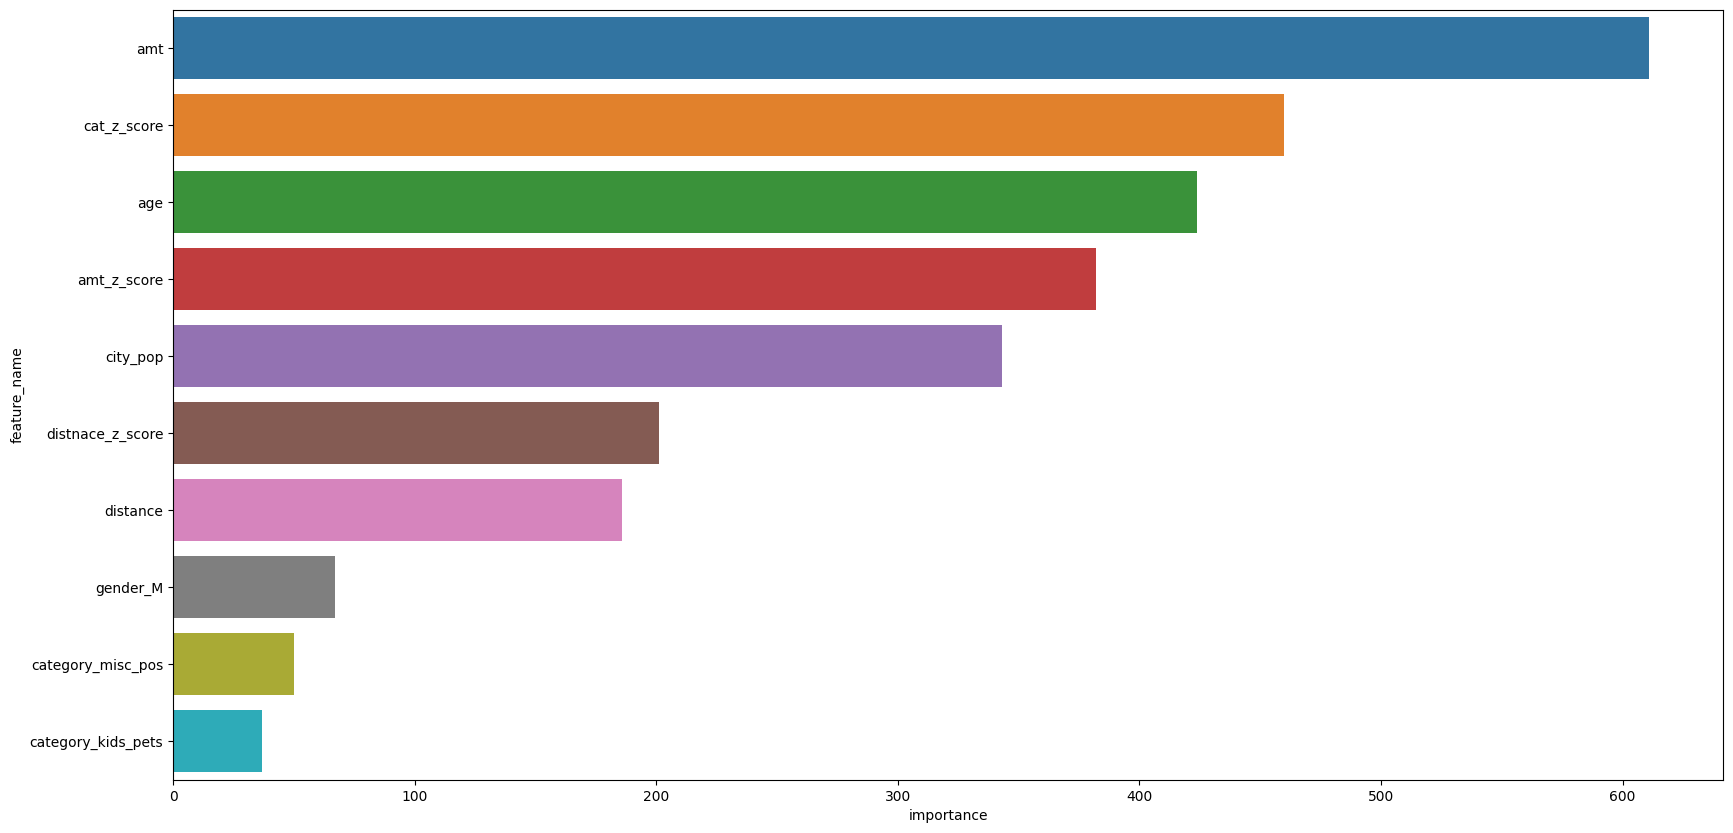

In [62]:
feature_imp = pd.DataFrame({'feature_name':X_train.columns, 'importance':model_1.feature_importances_}).sort_values('importance', ascending=False)  # 중요 변수
plt.figure(figsize=(20,10))
sns.barplot(x='importance', y='feature_name', data=feature_imp.head(10))
plt.show()

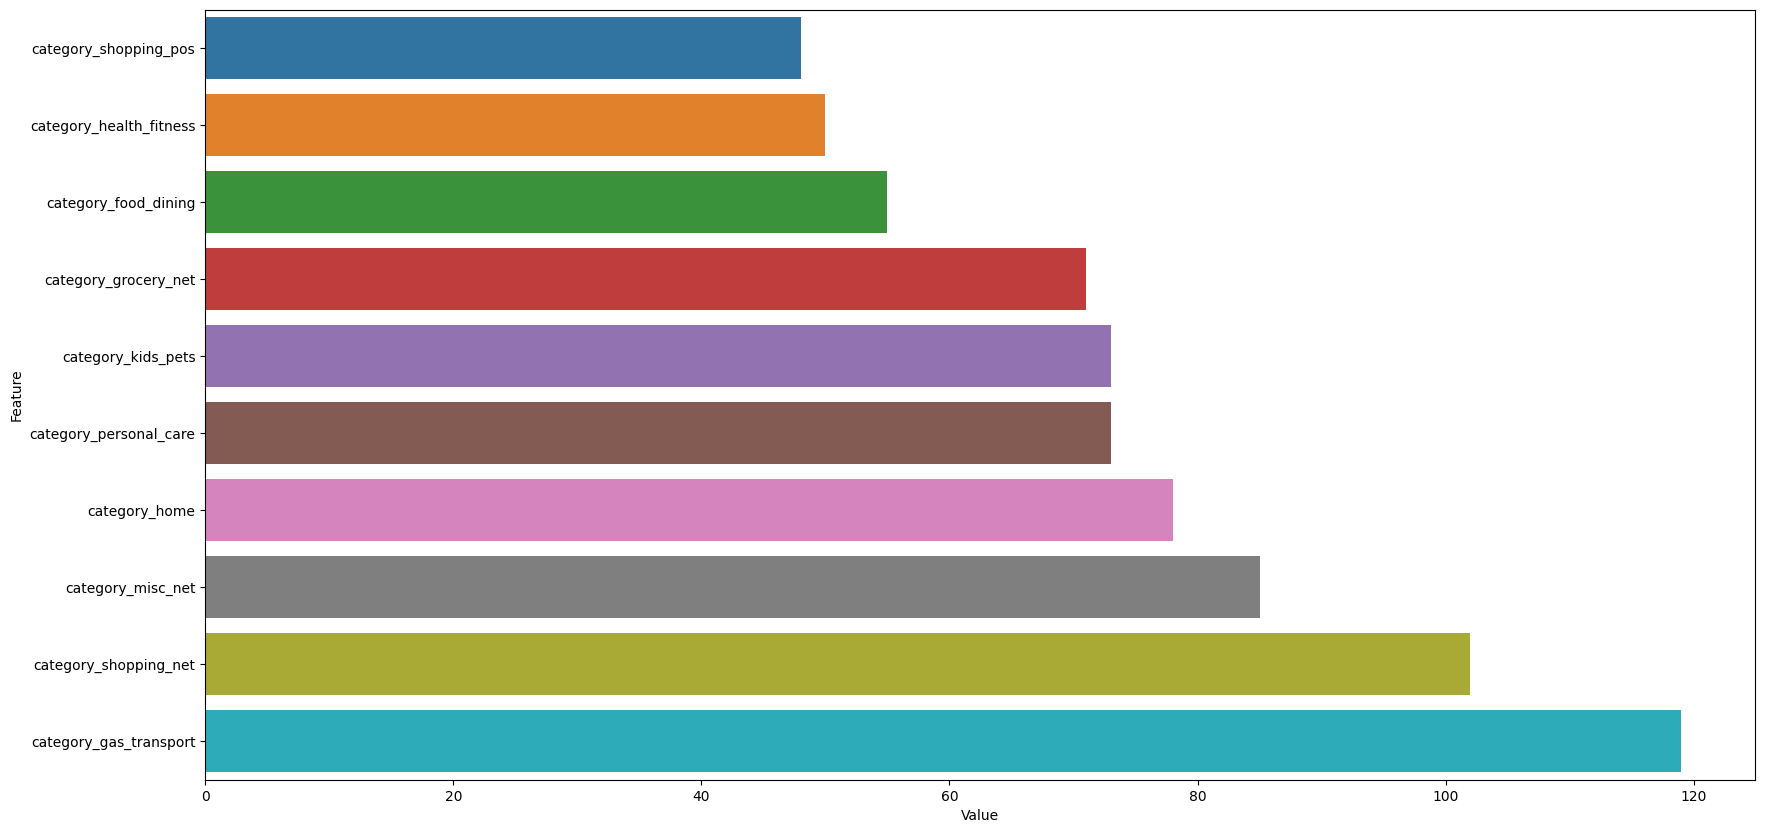

In [71]:
feature_imp_3 = pd.DataFrame(sorted(zip(model_3.feature_importance(), X_train.columns)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp_3.head(10))
plt.show()

## 모델 이해하기
XGBoost와 LightGBM의 가장 큰 차이점: 트리의 가지를 어떤 식으로 뻗어나가는가
- XGBoost는 균형 분할 방식으로, 각 노드에서 같은 깊이를 형성하도록 한층 한층 밑으로 내려옴
- LightGBM은 리프 중심 트리 분할 방식으로, 특정 노드에서 뻗어나가는 가지가 모델의 개선에 더 도움이 된다면 좌우 노드 수가 균등하지 않고 가지가 깊게 펼쳐짐

LightGBM은 속도가 훨씬 빠르게 진행될 수 있으며, 복잡성은 더 증가하고, 오버피팅 문제를 야기할 가능성 또한 높음
- 하이퍼파라미터 튜닝으로 극복 가능

XGBoost 대비 LightGBM의 장점
- 빠른 학습 및 예측
- 더 적은 메모리 사용
- 데이터셋 자동 변환 및 최적 분할